## Based on [RL adventures](https://github.com/higgsfield/RL-Adventure/blob/master/1.dqn.ipynb)

In [0]:
#@title Imports (RUN ME!)


# Note: enviroments like CartPole-v0 require a display to render. We need to install pyvirtualdisplay etc 
# in order to render from these environments

!pip install pyglet~=1.3.2 > /dev/null 2>&1
!pip install 'gym[atari]' > /dev/null 2>&1
!apt-get install python-opengl -y > /dev/null 2>&1
!apt install xvfb -y > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install flax > /dev/null 2>&1

from IPython.display import HTML

# Start virtual display
from pprint import pprint
import logging
from pyvirtualdisplay import Display
logging.getLogger("pyvirtualdisplay").setLevel(logging.ERROR)

display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

import matplotlib.animation

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        action = int(jnp.argmax(agent(obs)))        
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

# Imports

In [0]:
import jax
from jax import jit, grad, vmap
import jax.numpy as jnp
from flax import nn, optim

import gym
from functools import partial
import numpy as np

import random
from IPython.display import clear_output
from collections import deque
from typing import Callable, Mapping, NamedTuple, Tuple, Sequence

import matplotlib.pyplot as plt
%matplotlib inline
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [0]:
NUM_EPISODES = 10000
BATCH_SIZE   = 32
GAMMA        = 0.99

# Deep Q Network

In [0]:
class DQN(nn.Module):
  def apply(self, x, num_actions):
    x = nn.Dense(x, 128)
    x = nn.relu(x)
    x = nn.Dense(x, 128)
    x = nn.relu(x)
    y = nn.Dense(x, num_actions)
    return y

  # @nn.module_method
  # def act(self, x, epsilon, num_actions):
  #   prob = jax.random.uniform(jax.random.PRNGKey(0))
  #   q = self.call(x, num_actions)
  #   if prob < epsilon:
  #     a = jax.random.randint(num_actions)
  #   else:
  #     a = jnp.argmax(q)
  #   return a


# Replay Buffer

In [0]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = jnp.expand_dims(state, 0)
        next_state = jnp.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return {'state': jnp.concatenate(state), 'action':jnp.asarray(action), 
                'reward':jnp.asarray(reward), 
                'next_state':jnp.concatenate(next_state), 'done':jnp.asarray(done)}
    
    def __len__(self):
        return len(self.buffer)

# $\epsilon$-Greedy

In [0]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * jnp.exp(-1. * frame_idx / epsilon_decay)

# Training

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [0]:
def rand(key, num_actions):
  return jax.random.randint(key, (1,), 0, num_actions)[0]

@jit
def policy(model, key, x, epsilon, num_actions):
  prob = jax.random.uniform(key)
  q = model(x)
  rnd = partial(rand, num_actions=num_actions)
  a = jax.lax.cond(prob < epsilon, key, rnd, q, jnp.argmax)
  return a


@vmap
def q_learning_loss(q, max_q, action, reward, done):
  target_q = reward + max_q*(1.- done)
  td_error = target_q - q[action]
  return td_error**2

@jit
def train_step(optimizer, target_model, batch, gamma):
  def loss_fn(model):
    q = model(batch['state'])
    done = batch['done']
    max_q = gamma*jnp.max(target_model(batch['next_state']), axis=-1)
    return jnp.mean(q_learning_loss(q, max_q, batch['action'], batch['reward'],
                                    batch['done']))

  loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss

def main_loop():
  # Build env
  env_id = "CartPole-v0"
  env = gym.make(env_id)
  replay_buffer = ReplayBuffer(1000)

  #logging
  losses = []
  all_rewards = []
  episode_reward = 0
  key = jax.random.PRNGKey(0)

  # Build and initialize Q-network.
  num_actions = env.action_space.n
  state = env.reset()
  module = DQN.partial(num_actions=num_actions)
  _, initial_params = module.init(key, state)
  model = nn.Model(module, initial_params)
  target_model = nn.Model(module, initial_params)

  # Build and initialize optimizer.
  optimizer = optim.Adam(1e-3).create(model)

  for idx in range(1, NUM_EPISODES+1):
    key, _ = jax.random.split(key)
    epsilon = epsilon_by_frame(idx)

    #Act in the environment and update replay_buffer
    action = policy(optimizer.target, key, state, epsilon, num_actions)  
    next_state, reward, done, _ = env.step(int(action))
    replay_buffer.push(state, action, reward, next_state, done)
    
  
    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > BATCH_SIZE:
      batch = replay_buffer.sample(BATCH_SIZE)
      optimizer, loss = train_step(optimizer, target_model, batch, GAMMA)
      losses.append(float(loss))
        
    if idx % 200 == 0:
     plot(idx, all_rewards, losses)
      
    #Update Target model parameters
    if idx % 100 == 0:
      target_model = target_model.replace(params=optimizer.target.params)

  return optimizer.target 

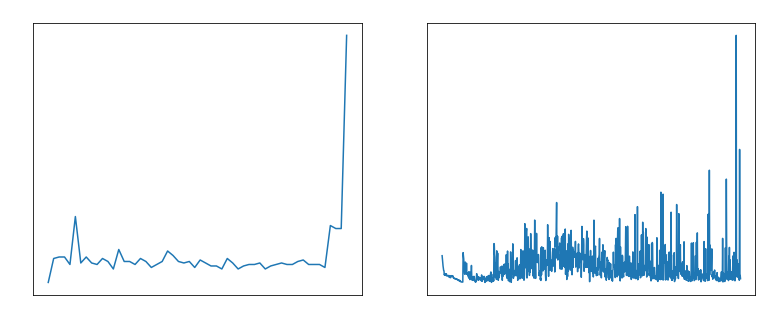

In [0]:
model = main_loop()

# Render trained agent

In [0]:
env_id = "CartPole-v0"
env = gym.make(env_id)
animate_agent(env, model)